# **Llama from scratch**


# **Takeaways**

## **Always work iteratively: start small, stay certain, and build up.**


Our approach for implementing papers is:


*   Make all of the helper functions required to test your model quantitatively (data splits, training, plotting the loss).
*   Before you even look at the paper, pick a small, simple, and fast model that you've done in the past. Then make a helper function to evaluate the model qualitatively.
*   Start by picking apart different components of the paper, and then implementing them one-by-one, training and evaluating as you go.






## **Make sure your layers do what you think.**



*   Use `.shape` religiously `.assert` and `plt.imshow` are also your friends.

*   Work out the results without matrix multiplication first, and then use the torch functions to make it efficient after.

*   Have a test to see that your layer is right. For example, the RoPE embeddings have a specific property that you can test for. For the Transformer, you can test that the attention is working by looking at the attention map.

*   Test your layers on various batch, sequence, and embedding sizes. Even if it works for one size, it might not work for others, which will cause problems at inference time.





## **About Llama**

Llama is a transformer-based model for language modeling. Meta AI [open-sourced](https://github.com/facebookresearch/llama) Llama this summer, and it's gained a lot of attention (pun intended). When you're reading the introduction, they clearly indicate their goal: make a model that's cheaper for running inference, rather than optimizing training costs.



At this point, we'll just load our libraries and get started.



In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

## **Setting up our dataset**


While in Llama they train on 1.4T tokens, our dataset TinyShakespeare, the collection of all of Shakespeare's works, is about 1M characters.



In [2]:
lines = open('/content/input.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])


First Citizen:
Before we proce


They use the [SentencePiece](https://github.com/google/sentencepiece) byte-pair encoding tokenizer, but we're going to just use a simple character-level tokenizer.



In [3]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))


vocab size: 65


'hello'

Since our dataset is small enough, we don't need to worry about how we store it in memory etc.



First tip: We are creating a `config` object that stores some basic model params. It makes our code way more readable and removes constants and magic numbers from the code. We are not going to use types, as we want to keep things flexible for now and be able to add more parameters later on.



In [4]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}


In [5]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape


torch.Size([1115394])

Let's create a method to generate our training data and labels for batches. We'll use the same method for validation and test data. Note that we like to test our functions in the same block that we define them, just to make sure they work as expected before moving on.



In [6]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    batch_data = train
    if split == 'val':
        batch_data = val

    if split == 'test':
        batch_data = test

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

MASTER_CONFIG.update({
    'batch_size': 8,
    'context_window': 16
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('er dinner.\n\nFirs', 'r dinner.\n\nFirst'),
 ('CINIUS:\nConsul! ', 'INIUS:\nConsul! w'),
 ('h mine: I muse w', ' mine: I muse wh'),
 ('gh it but with t', 'h it but with th'),
 (' should not be;\n', 'should not be;\nA'),
 ('h a martial scor', ' a martial scorn'),
 ('\nSo leaves me to', 'So leaves me to '),
 ('e of majesty, wa', ' of majesty, war')]

What's interesting about implementing papers is that there are two aspects to the model working: compilation (do your tensors all match up from layer to layer), and training (does the loss go down). Figuring out how to ensure that each of your compoenents is working is key to developing your model in a predictable, engineering-minded way.



That's why we're also going to define the method for how we're going to evaluate the model. We want to do this before we even define the model, because we want to be able to use it to evaluate the model as we're training it.



In [7]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

## **Setting up a working base model**

Here's a basic feed-forward neural network with embeddings. It's the base model we're going to start with, and then swap out parts of it as we go along until we eventually end up with the model as described in Llama.



In [8]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)
        logits = F.softmax(a, dim=-1)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

MASTER_CONFIG.update({
    'd_model': 128,
})
model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)

model params: 33217


It's at this point that we have to start worrying about the shape of our tensors and making indices match. Check out this line of our model definition:



```
loss = F.cross_entropy(logits.view(-1, config['vocab_size']), targets.view(-1))
```



We have to reshape the `logits` and `targets` tensors so that their dimensions match when we compare. We do this with the `view` method. The `-1` argument means "infer this dimension from the others". So, in this case, we're saying "reshape `logits` and `targets` to have the same number of rows, and however many columns are needed to make that happen". This is a common pattern when you're working with batches of data.

Alright, let's train our `SimpleBrokenModel` to make sure gradients flow. After we confirm that, we can swap out parts of it to match Llama, train again, and track our progress. It's at this point that we start keeping a log of our training runs, so that we can easily just go back to a previous run in the event that we mess something up.

In [9]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10,
    'batch_size': 32,
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(),
)



model params: 33217


validation loss:  3.946973419189453


<Axes: >

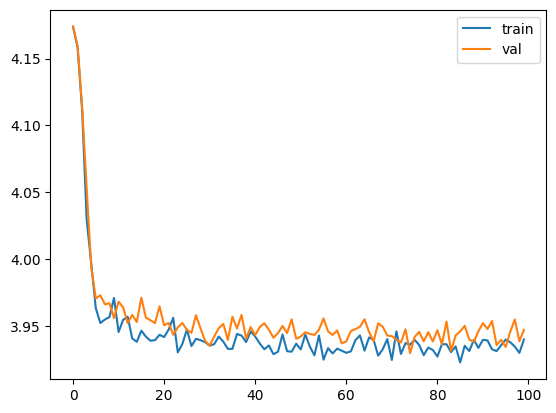

In [10]:
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

Notice how we get a training curve that goes down, but barely by anything. How do we know it's barely training? We have to use first principles. The cross-entropy loss before training is 4.17, and after 1000 epochs is 3.93. How can we make sense of it intuitively?



Cross-entropy in this context is referring to how likely we are to pick the wrong word. So here,




$H(T,q) = - \sum_{i=1}^{N} \frac{1}{N} \log q(x_{i})$

where $q(x_i)$ is the probability of picking the right word, as estimated by the model. If $q(x_i)$ is close to 1, then $\log q$ is close to 0; similarly, if $q$ is small, then $\log q$ is a large negative number, so $-\log q$ will be a large positive number. Now to build the intuition: to start, $-\log q = 4.17$, so $q = 0.015$, or around $\frac{1}{64.715}$. Recall that the vocabulary size $|V| = 65$, so what we're basically saying here is that the model is as good at choosing the next letter as randomly picking from our vocabulary. After training, $-\log q = 3.93$, so we're now basically choosing between 50 letters. This is a very small improvement, so something is probably wrong.

To get an intuition for how the loss relates to the model's performance, think about the model choosing among $\tilde V$ tokens; when $\tilde V$ is small, the model is more likely to guess right. In addition, we know $\max \tilde V = V$, which can help us understand if our model is learning at all.

$\tilde V = \exp(L)$

Let's try to debug what's going on. Notice that in our model we're using a softmax layer on our logits, which is a function that takes a vector of numbers and squashes them into a probability distribution. But for using the built in `F.cross_entropy` function, we need to pass in the [unnormalized logits directly](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html). So let's remove that from our model and try again.

In [11]:
class SimpleModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits


model params: 33217
validation loss:  2.4983184576034545


<Axes: >

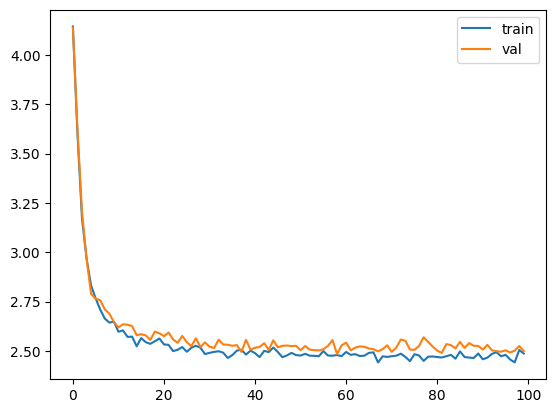

In [12]:
model = SimpleModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Great, now our loss is $2.54$, so we're choosing from $12.67$ characters. That's way better than the 65 we started with. Let's add a generate method to our model so we visually see the results of our model.



In [13]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

generate(model)

['\n\nRY:\n\n\nH:\n\nTostoe he, n ncoren',
 '\n\nTh y tease r arthe bereenice.',
 '\nFo we wer the,,\n\nAn.\nYotothige',
 '\nId Chasit belll t, is war f d ',
 '\nF ther fur pe\n\n\nW, stimich we;']

It's not half bad, but also not half good. But now we have a working model that is training to a validation loss. So here we'll iterate on our model to make it closer to Llama.

## **Llama specifics**


Llama describes three architectural modifications to the original Transformer:

1.   RMSNorm for pre-normalization
2.   Rotary embeddings
3.   SwiGLU activation function

We're going to add each one, one at a time to our base model, and iterate.

### **RMSNorm**

In Vaswani 2017, the original transformer uses BatchNormalization. In Llama, the authors use RMSNorm, which is where you scale the bector by the variance without centering it. In addition, while Vaswani applies normalization to the output of the attention layer (post-normalization), Llama applies it to the inputs before (pre-normalization).



In [14]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'], config['d_model']))
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


We want to test to ensure that the RMSNorm is doing what we think it should. We can do this the old-fashioned way: row-wise comparisons. The RMSNorm has the property where the norm of the layer will be the square root of the number of elements in the layer, so we can check that for every layer.



In [15]:
rms = torch.linalg.norm(batch, dim=(1,2)) * (batch[0].numel() ** -.5)

# scaled_batch.var(dim=(1,2))
assert torch.linalg.norm( torch.arange(5).float() ) == (torch.arange(5).float() ** 2 ).sum() ** .5
rms = torch.linalg.norm( torch.arange(5).float() ) * (torch.arange(5).numel() ** -.5)
assert torch.allclose(torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch.shape[1:].numel() ** -.5

# RMS for sure
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]
assert torch.allclose(torch.linalg.norm(ffx, dim=(1,2)) ** 2, torch.tensor(143).float())
assert torch.allclose(ffx, g)


Alright, so that's RMSNorm, and it seems like it's working. Again, let's test it out.



model params: 35265
validation loss:  2.508118748664856


<Axes: >

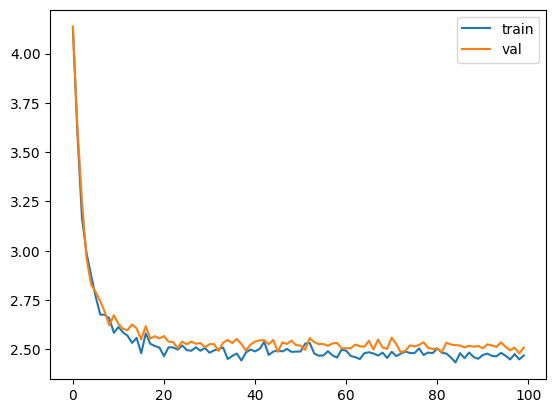

In [16]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel_RMS(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)


So RMSNorm works, and it got our loss down by a small amount.



## **Rotary Embeddings**


[RoPE](https://arxiv.org/pdf/2104.09864.pdf) is a kind of positional encoding for transformers. In Attention is All You Need, the authors propose two kinds of positional encodings, learned and fixed. In RoPE, the authors propose embedding the position of a token in a sequence by rotating the embedding, with a different rotation at each position.

In [17]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

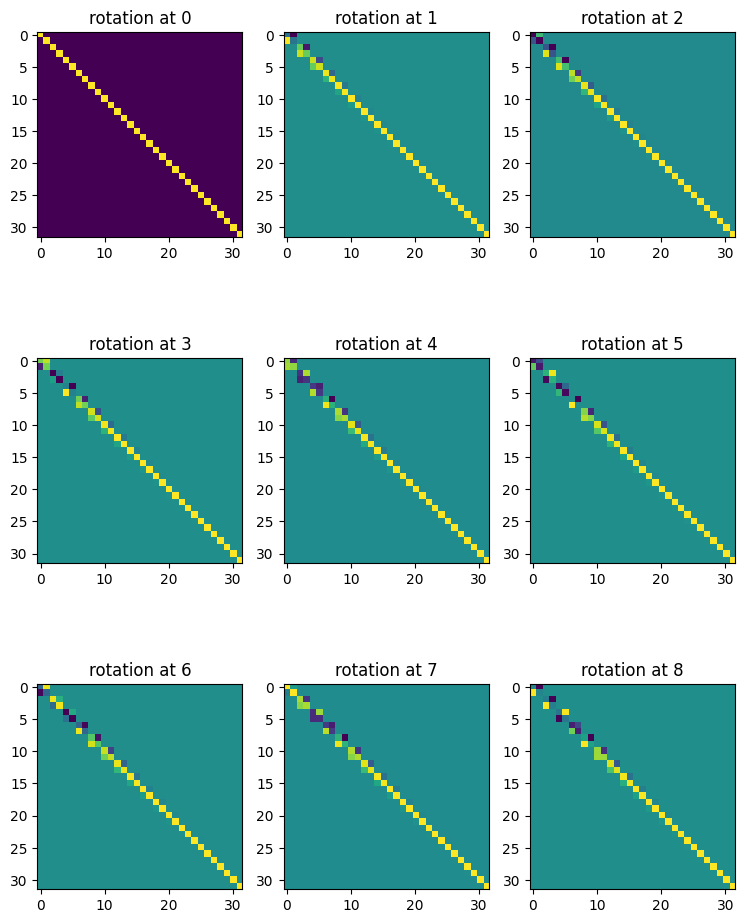

In [18]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

Let's make sure these work. They should exhibit the quality that


$q_{m}^{T} = (R_{\theta,m}^{d} W_{q} x_{m})^{T} (R_{\theta,n}^{d} W_{k} x_{n}) = x^{T} W_{q} R_{\theta,n-m}^{d} W_{k} x_{n}$

In [19]:
config = {
    'd_model': 128,
    'context_window': 16,
}

R = get_rotary_matrix(config['context_window'], config['d_model'])
x = torch.randn(config['d_model'])
y = torch.randn(config['d_model'])

m = 3
n = 13

x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y

assert torch.isclose(x_m @ x_n, x @ R[n-m,:,:] @ y)

So the RoPE rotations work as expected.



In [20]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1
        )

        if return_attn_weights:
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d)
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

In [21]:
layer = RoPEAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)




- - -
**Tip here:** know the difference between tensor dimensions at train time vs tensor dimensions at inference time.




Although at train time, you can expect your tensor dimensions to match your model parameters closely, eg `batch.shape = (config['batch_size'], config['context_window'], config['d_model'])`, at inference time, you may have to deal with a single example, eg `batch.shape = (1, 1, config['d_model'])`. For this reason, you need to make sure that when you're indexing in the forward pass, you're indexing using shapes derived from the input, not necessarily the model parameters.



Let's make sure it does what we think it does. For this layer, we're going to want to test three things:

1.  that it rotates embeddings the way we think it does
2.  that the attention mask used for causal attention is working properly.


In [22]:
x = torch.randn((config['batch_size'], config['context_window'], config['d_model']))

q = layer.w_q(x)
k = layer.w_k(x)
v = layer.w_v(x)

q_rotated = torch.zeros_like(x)
k_rotated = torch.zeros_like(x)
v_rotated = torch.zeros_like(x)

for position in range(config['context_window']):
    q_rotated[:,position,:] = torch.matmul(q[:,position,:], layer.R[position,:,:])
    k_rotated[:,position,:] = torch.matmul(k[:,position,:], layer.R[position,:,:])
    v_rotated[:,position,:] = torch.matmul(v[:,position,:], layer.R[position,:,:])

q_rotated = (torch.bmm(q.transpose(0,1), layer.R)).transpose(0,1)
k_rotated = (torch.bmm(k.transpose(0,1), layer.R)).transpose(0,1)
v_out = (torch.bmm(v.transpose(0,1), layer.R)).transpose(0,1)

assert torch.allclose(q.transpose(0,1)[0], q[:,0,:])
assert torch.allclose(q.transpose(0,1)[0] @ layer.R[0], q[:,0,:] @ layer.R[0])
assert torch.allclose(q_rotated, q_rotated)

In [23]:
config = {
    'batch_size': 1,
    'd_model': 2,
    'n_heads': 2,
    'context_window': 3,
}

layer = RoPEAttentionHead(config)
batch = torch.ones((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

m = 0
x_q = batch[0, m]
q = layer.R[m,:,:] @ layer.w_q(x_q)

assert torch.allclose(layer.w_q(x_q), layer.w_q.weight @ x_q)
assert torch.allclose(q, layer.R[m, :, :] @ layer.w_q.weight @ x_q)

n = 2
x_k = batch[0, n]
k = layer.R[n,:,:] @ layer.w_k(x_k)

assert torch.allclose(layer.w_k(x_k), layer.w_k.weight @ x_k)
assert torch.allclose(k, layer.R[n, :, :] @ layer.w_k.weight @ x_k)

assert q.T @ k == q @ k # transpose is redundant
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n, :, :].T @ layer.R[m, :, :] @ layer.w_q.weight @ x_q)
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n-m, :, :].T @ layer.w_q.weight @ x_q)

<ipython-input-23-245f86892ec1>:26: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  assert q.T @ k == q @ k # transpose is redundant


Let's setup a multi-headed attention layer for this singular attention head and see what happens when we train.



In [24]:
# definitely there's an optimization we could make where we cache the rotation matrices, but skip.
class RoPEMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


In [25]:

MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEMultiheadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

In [26]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits


model params: 559681
validation loss:  0.15945952087640763


<Axes: >

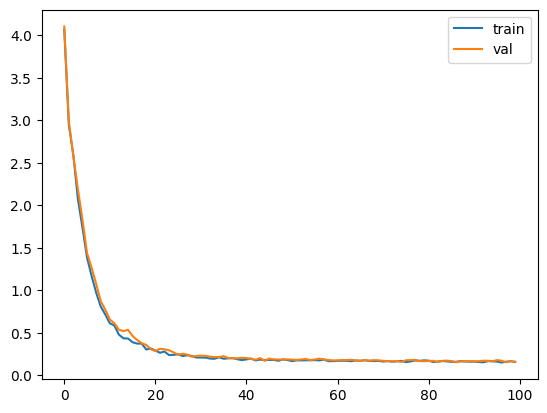

In [27]:
model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Wow, would you look at that, our validation loss is down to .16. That is so low...it's almost too low. Consider the check we used from above: $\exp(.16) = 1.17$, so it's as if the model is choosing basically next character correctly every time. Let's see what happens when we generate.



In [28]:
generate(model, config=MASTER_CONFIG)

['\n\n\nOOOOOOOOOOOOOOOOOOOOOOOOOOOO',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nOOUOUUKEOMO',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nISIS:\nFILI:\nA',
 '\n\n\n\n\n\n\n\n\n\n\n\n\nIAALULULUUU:\nAu uk',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nTTIT:\nAThe no s']

So it looks terrible. What is happening here? Let's start debugging this by looking at the attention.



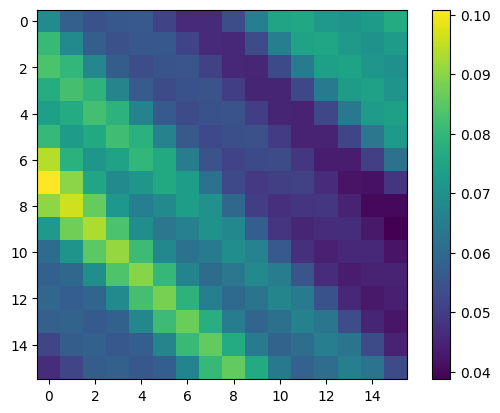

In [29]:
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy(), interpolation='nearest')
plt.colorbar()


So here we see that all the attention is lit up, meaning that characters in any position are attending to characters in any other position. What's bad about this? We are trying to predict the next token solely on the tokens that came before it, but here we're seeing that the model is attending to tokens that come after it. In other words, the model is cheating, or leaking information from the future. This is a problem, and it's why we need to use a causal mask.



In [30]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations


In [31]:
layer = RoPEMaskedAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

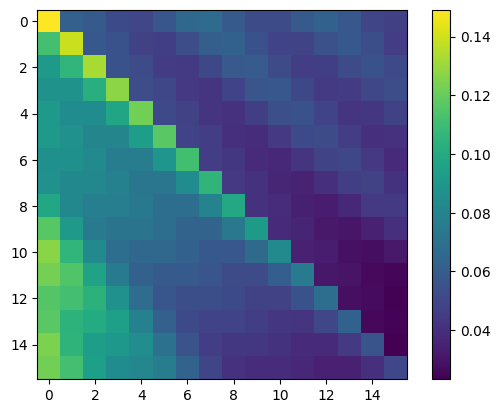

In [32]:
layer = RoPEMaskedAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()


Now, we can see that the upper triangular of our attention activations (the part that corresponds to the future) is nearly zeroed out. Let's see what happens when we train.



In [33]:
# definitely there's an optimization we could make where we cache the rotation matrices, but skip.
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


In [34]:
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEMultiheadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

In [35]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits


model params: 559681
validation loss:  2.090113043785095


<Axes: >

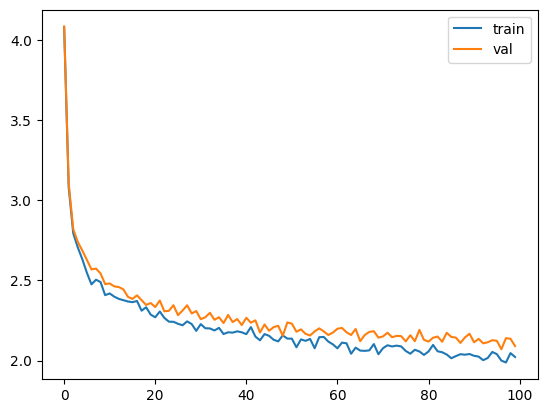

In [36]:
model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Much better, our loss is now not merely dropping to near-zero. It looks like we can drive our loss down even lower. Let's do that by updating master config.



validation loss:  1.9152989864349366


<Axes: >

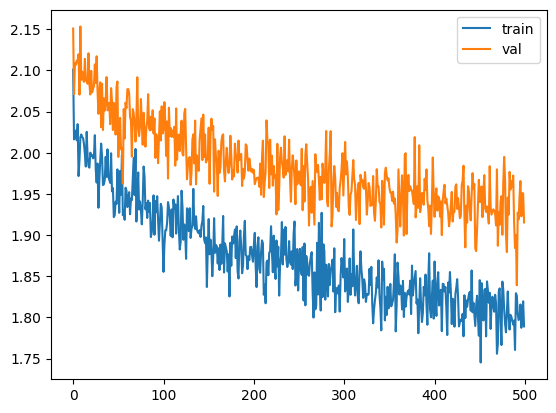

In [37]:
MASTER_CONFIG.update({
    "epochs": 5000,
    "log_interval": 10,
})
train(model, optimizer)


## **SwiGLU**

As it says in the paper, "We replace the ReLU non-linearity by the SwiGLU activation function...we use a dimension of $\frac{2}{3} 4d$ instead of $4d$ as in PaLM." SwiGLU is defined as: $ \text{SwiGLU}(x) = \text{Swish}\beta (xW + b) \otimes (xV + c)$

$\text{Swish}\beta(x) = x \sigma(\beta x) $ where $\beta$ is a learnable parameter.

In [38]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out


In [39]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits


model params: 592706
validation loss:  1.9047449946403503


<Axes: >

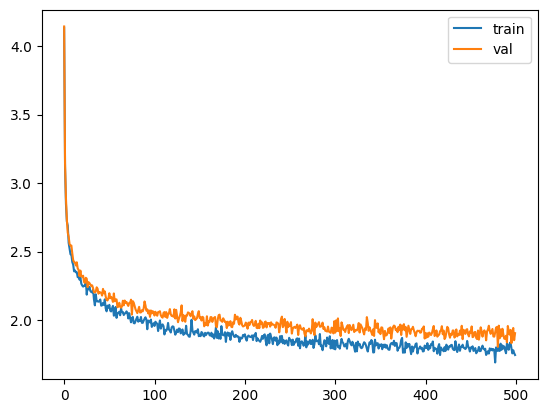

In [40]:
model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Now, let's add multiple layers of RopeAttention by creating blocks.



In [41]:
# add RMSNorm and residual conncection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))

        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

In [42]:
block = LlamaBlock(MASTER_CONFIG)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']));


In [43]:
from collections import OrderedDict

MASTER_CONFIG.update({
    'n_layers': 4,
})
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss


model params: 2370246
validation loss:  1.6412315964698792


<Axes: >

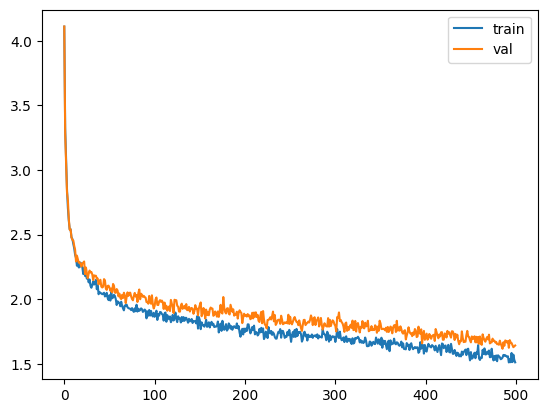

In [44]:
llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG)


It looks like we can drive the loss down even more, and although we're overfitting a little, I think we can still do better. Let's train longer.



validation loss:  1.1805177927017212


<Axes: >

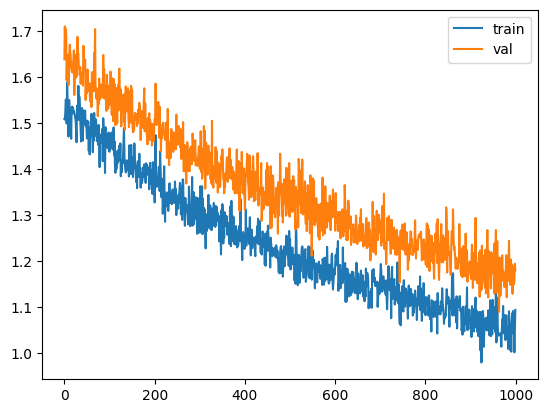

In [45]:
MASTER_CONFIG.update({
    'epochs': 10000,
})
train(llama, optimizer, scheduler=None, config=MASTER_CONFIG)


It seems we can go even lower, still without serious overfitting. Either there is a leak, or it's actually doing well. The loss here is 1.08, which is equivalent to choosing between 2.9 tokens randomly.



validation loss:  0.992376047372818


<Axes: >

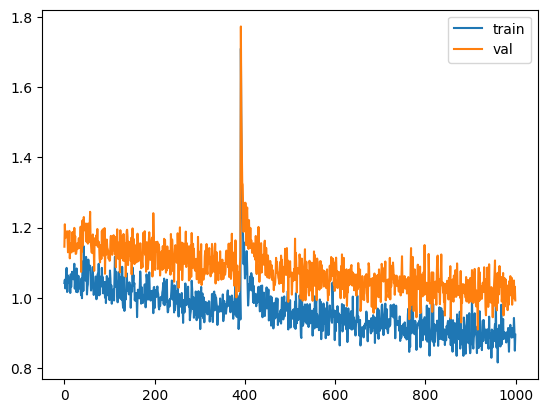

In [46]:
train(llama, optimizer, config=MASTER_CONFIG)


In [47]:
print(generate(llama, MASTER_CONFIG, 500)[0])




-EvE WARD WAper:
You he have woe then nor. Loves fage greatning,
We spartsure a these;
The streblen,
That there lience
'er holy?

MENENIUS:
Ot 'tweer; multing hoptym'll
Let not co youther haze lives,
And Imberred ut high forswed moquelsedies matcens,
Bleaceive men this, ded.

Now now with part as opeat, do that give, I shall brards where, is Tadom's im onlow for ver fill were natherwhere made and hoirat
Fral son
As meartile it chalt dearint:
With namlesh set, once hearts thrue held for my heads


At this point, we've hit the bottom with our training. Let's test on the test set.



In [48]:
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = llama(xs, ys)

print(loss)

tensor(1.1910, grad_fn=<NllLossBackward0>)


# **Miscellaneous**


## **Check for Gradient Flows**

Let's inspect the gradients, we want to see how they're flowing. If there are too many gradients where the value is close to 0, that's a problem.



In [49]:
# print the percentage that are near 0
def show_grads(model, tol=1e-2):
    return sorted([(name, 100.0 * float(torch.sum(torch.abs(param) <= tol)) / float(param.nelement())) for name, param in model.named_parameters() if param.requires_grad], key=lambda t: t[1], reverse=True)

show_grads(llama)

[('llama_blocks.llama_3.attention.heads.1.w_v.weight', 23.05908203125),
 ('llama_blocks.llama_3.attention.linear.weight', 22.68829345703125),
 ('llama_blocks.llama_3.attention.heads.5.w_v.weight', 22.1435546875),
 ('llama_blocks.llama_3.attention.heads.2.w_v.weight', 21.77734375),
 ('llama_blocks.llama_2.attention.linear.weight', 19.600677490234375),
 ('llama_blocks.llama_0.attention.linear.weight', 19.429779052734375),
 ('llama_blocks.llama_2.attention.heads.1.w_v.weight', 18.78662109375),
 ('llama_blocks.llama_3.attention.heads.4.w_v.weight', 17.17529296875),
 ('llama_blocks.llama_1.attention.linear.weight', 16.277313232421875),
 ('llama_blocks.llama_3.attention.heads.6.w_v.weight', 16.253662109375),
 ('llama_blocks.llama_2.attention.heads.5.w_v.weight', 16.217041015625),
 ('llama_blocks.llama_3.attention.heads.0.w_v.weight', 15.875244140625),
 ('llama_blocks.llama_2.attention.heads.4.w_v.weight', 15.618896484375),
 ('llama_blocks.llama_3.attention.heads.3.w_v.weight', 15.07568359375

Here, for all of our parameter gradients, the vast majority are non-zero, which is great. If we start to see this number peak higher, then our gradients would not be flowing.



### **Experiment with hyperparams, aka "change the oven settings"**


In the original Llama paper, the authors use Cosine Annealing learning schedule. We didn't do that here, because I experimented and saw that it was worse.



model params: 2370246


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:809: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


lr:  [0.0009999457184159408]
lr:  [0.0009961510274583004]
lr:  [0.0009869757772816292]
lr:  [0.0009725204933511963]
lr:  [0.0009529435502760634]
lr:  [0.0009284594366176498]
lr:  [0.0008993364049014041]
lr:  [0.0008658935325782156]
lr:  [0.0008284972261358946]
lr:  [0.0007875572066618724]
lr:  [0.0007435220208394261]
lr:  [0.0006968741265588948]
lr:  [0.0006481246069855613]
lr:  [0.0005978075709959357]
lr:  [0.0005464743013294258]
lr:  [0.0004946872145648923]
lr:  [0.00044301369909075325]
lr:  [0.00039201989856974814]
lr:  [0.0003422645089892466]
lr:  [0.0002942926572257539]
lr:  [0.0002486299281339155]
lr:  [0.0002057766054928797]
lr:  [0.00016620218969383484]
lr:  [0.00013034025177986015]
lr:  [9.85836791664324e-05]
lr:  [7.128036241775617e-05]
lr:  [4.872936226262451e-05]
lr:  [3.117756953567661e-05]
lr:  [1.8816750064937722e-05]
lr:  [1.1779739336260682e-05]
lr:  [1.0054282328142978e-05]
lr:  [1.396862020283371e-05]
lr:  [2.3138198807489664e-05]
lr:  [3.7591595433673565e-05]
lr:  [

<Axes: >

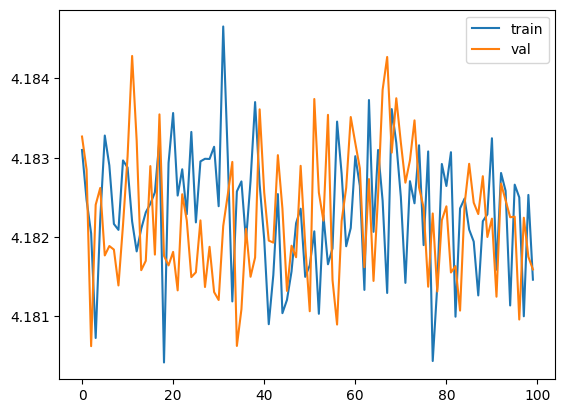

In [50]:
MASTER_CONFIG.update({
    "epochs": 1000
})
llama_with_cosine = Llama(MASTER_CONFIG)
llama_optimizer = torch.optim.Adam(
    llama.parameters(),
    betas=(.9, .95),
    weight_decay=.1,
    eps=1e-9,
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)
train(llama_with_cosine, llama_optimizer, scheduler=scheduler)


In [51]:
show_grads(llama_with_cosine, 1e-5)

[('llama_blocks.llama_1.attention.linear.weight', 0.0396728515625),
 ('llama_blocks.llama_0.attention.linear.weight', 0.034332275390625),
 ('llama_blocks.llama_3.attention.linear.weight', 0.0335693359375),
 ('llama_blocks.llama_2.attention.heads.1.w_q.weight', 0.030517578125),
 ('llama_blocks.llama_2.feedforward.0.weight', 0.030517578125),
 ('llama_blocks.llama_2.attention.linear.weight', 0.0274658203125),
 ('llama_blocks.llama_1.attention.heads.3.w_q.weight', 0.0244140625),
 ('llama_blocks.llama_1.attention.heads.6.w_k.weight', 0.0244140625),
 ('llama_blocks.llama_1.feedforward.0.weight', 0.0244140625),
 ('llama_blocks.llama_2.attention.heads.3.w_q.weight', 0.0244140625),
 ('llama_blocks.llama_2.feedforward.1.linear.weight', 0.0244140625),
 ('llama_blocks.llama_3.attention.heads.2.w_v.weight', 0.0244140625),
 ('llama_blocks.llama_3.attention.heads.5.w_q.weight', 0.0244140625),
 ('ffn.0.weight', 0.0244140625),
 ('llama_blocks.llama_0.attention.heads.0.w_v.weight', 0.018310546875),
 ('l

Even at an extremely low tolerance, the attention biases are not getting any signal. I'm not sure why the learning schedule from the paper doesn't work, but the lesson here is simple: start simple.


